# Saliency Mapping: What Words Trigger "AI" Detection?

## Approach
1. Load the trained DistilBERT+LoRA model (Tier C)
2. Use **Captum LayerIntegratedGradients** for token-level attribution
3. Highlight words in **Imposter AI** paragraphs that most strongly signal "AI"
4. Identify outlier examples (Imposter texts the model finds most/least AI-like)
5. Export findings for analysis.tex

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from peft import PeftModel, PeftConfig
from captum.attr import LayerIntegratedGradients, visualization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
sns.set_style('whitegrid')

Using device: cuda


In [2]:
# ============ Load Model ============
model_path = './transformer_final_model'
base_model_name = 'distilbert-base-uncased'

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(base_model_name)

# Load base model + LoRA adapter
base_model = DistilBertForSequenceClassification.from_pretrained(
    base_model_name, num_labels=2, problem_type='single_label_classification'
)
model = PeftModel.from_pretrained(base_model, model_path)
model = model.merge_and_unload()  # merge LoRA weights into base for clean forward pass
model.to(device)
model.eval()
print(f'\u2713 Model loaded and merged on {device}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded and merged on cuda


In [3]:
# ============ Load Data ============
source_path = '../../data_analysis/data.parquet'
df_raw = pd.read_parquet(source_path)

features_expanded = pd.json_normalize(df_raw['feature_cache'])
df = pd.concat([df_raw[['id', 'class', 'topic', 'text']].reset_index(drop=True),
                features_expanded[['author']].reset_index(drop=True)], axis=1)

df['label'] = (df['class'] > 1).astype(int)

# Filter to Imposter AI (class 3) for saliency analysis
imposter_df = df[df['class'] == 3].copy().reset_index(drop=True)
human_df = df[df['class'] == 1].copy().reset_index(drop=True)
standard_ai_df = df[df['class'] == 2].copy().reset_index(drop=True)

print(f'Total samples: {len(df)}')
print(f'Imposter AI (Class 3): {len(imposter_df)}')
print(f'Human (Class 1): {len(human_df)}')
print(f'Standard AI (Class 2): {len(standard_ai_df)}')

Total samples: 1508
Imposter AI (Class 3): 504
Human (Class 1): 500
Standard AI (Class 2): 504


In [4]:
# ============ Score ALL texts to find outliers ============
def get_predictions(texts, batch_size=16):
    """Get P(AI) for a list of texts."""
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, truncation=True, padding=True,
                        max_length=256, return_tensors='pt').to(device)
        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        all_probs.extend(probs)
    return np.array(all_probs)

# Score all classes
imposter_df['prob_ai'] = get_predictions(imposter_df['text'].tolist())
human_df['prob_ai'] = get_predictions(human_df['text'].tolist())
standard_ai_df['prob_ai'] = get_predictions(standard_ai_df['text'].tolist())

print('=== Imposter AI P(AI) distribution ===')
print(f'  Mean: {imposter_df["prob_ai"].mean():.4f}')
print(f'  Median: {imposter_df["prob_ai"].median():.4f}')
print(f'  Min: {imposter_df["prob_ai"].min():.4f} (most human-like)')
print(f'  Max: {imposter_df["prob_ai"].max():.4f}')
print(f'  Classified as Human (P<0.5): {(imposter_df["prob_ai"] < 0.5).sum()}')

print('\n=== Human P(AI) distribution ===')
print(f'  Mean: {human_df["prob_ai"].mean():.4f}')
print(f'  Classified as AI (P>0.5): {(human_df["prob_ai"] > 0.5).sum()}')

print('\n=== Standard AI P(AI) distribution ===')
print(f'  Mean: {standard_ai_df["prob_ai"].mean():.4f}')
print(f'  Classified as Human (P<0.5): {(standard_ai_df["prob_ai"] < 0.5).sum()}')

=== Imposter AI P(AI) distribution ===
  Mean: 0.9873
  Median: 1.0000
  Min: 0.0140 (most human-like)
  Max: 1.0000
  Classified as Human (P<0.5): 7

=== Human P(AI) distribution ===
  Mean: 0.0208
  Classified as AI (P>0.5): 5

=== Standard AI P(AI) distribution ===
  Mean: 1.0000
  Classified as Human (P<0.5): 0


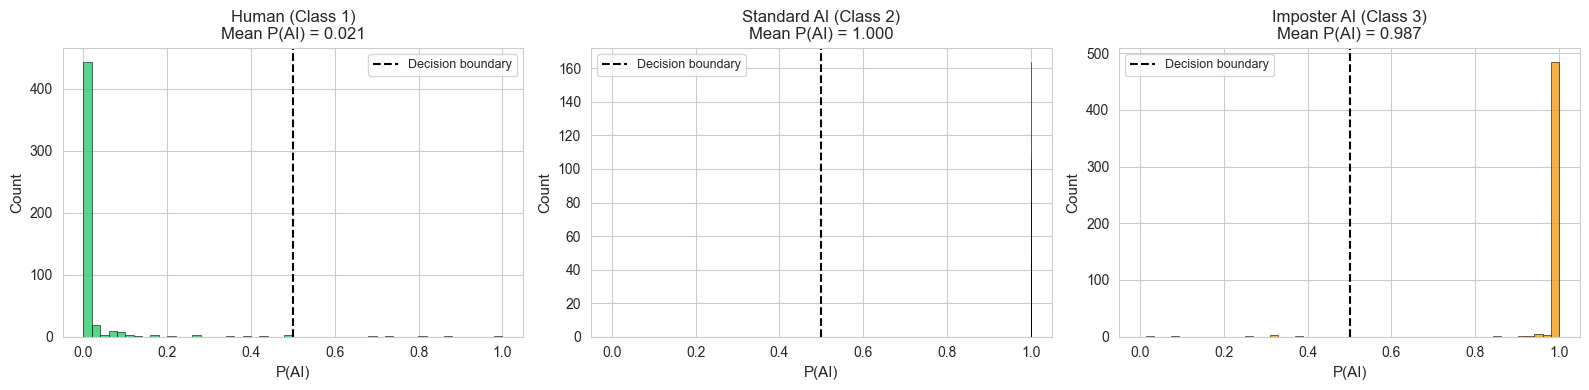

✓ Saved P(AI) distribution plot


In [5]:
# ============ Distribution of P(AI) by class ============
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, data, color) in zip(axes, [
    ('Human (Class 1)', human_df, '#2ecc71'),
    ('Standard AI (Class 2)', standard_ai_df, '#e74c3c'),
    ('Imposter AI (Class 3)', imposter_df, '#f39c12')
]):
    ax.hist(data['prob_ai'], bins=50, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.axvline(0.5, color='black', ls='--', lw=1.5, label='Decision boundary')
    ax.set_xlabel('P(AI)', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'{name}\nMean P(AI) = {data["prob_ai"].mean():.3f}', fontsize=12)
    ax.legend(fontsize=9)
    ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.savefig('../../analysis/figures/saliency_prob_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print('\u2713 Saved P(AI) distribution plot')

In [16]:
# ============ Captum: Saliency Attribution Setup ============
# Use a simple function-based forward (no nn.Module wrapper needed)
# The model natively supports inputs_embeds, so use that directly.

from captum.attr import IntegratedGradients

def forward_with_embeds(input_embeds, attention_mask):
    """Forward pass using embeddings directly through the full model."""
    batch_size = input_embeds.shape[0]
    # Expand attention mask if needed (Captum batches interpolation steps)
    if attention_mask.shape[0] != batch_size:
        attention_mask = attention_mask.expand(batch_size, -1)
    
    outputs = model(inputs_embeds=input_embeds, attention_mask=attention_mask)
    # Return logit for AI class
    return outputs.logits[:, 1]

def get_embeddings(input_ids):
    return model.distilbert.embeddings(input_ids)

ig = IntegratedGradients(forward_with_embeds)
print('\u2713 Captum IntegratedGradients initialized')

✓ Captum IntegratedGradients initialized


In [17]:
def compute_token_attributions(text, n_steps=50):
    """
    Compute token-level attributions via Integrated Gradients on embeddings.
    Returns: tokens, attributions (normalized), pred_prob
    """
    encoding = tokenizer(text, truncation=True, max_length=256, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get prediction
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        pred_prob = torch.softmax(logits, dim=1)[0, 1].item()
    
    # Get input embeddings and zero baseline
    input_embeds = get_embeddings(input_ids).detach().requires_grad_(True)
    baseline_embeds = torch.zeros_like(input_embeds)
    
    # Compute attributions (no internal batching to avoid mask expansion issues on GTX 1650)
    attributions = ig.attribute(
        inputs=input_embeds,
        baselines=baseline_embeds,
        additional_forward_args=(attention_mask,),
        n_steps=n_steps
    )
    
    # Sum across embedding dimension -> per-token attribution
    attr_sum = attributions.sum(dim=-1).squeeze(0)
    attr_sum = attr_sum / (torch.norm(attr_sum) + 1e-8)
    attr_np = attr_sum.cpu().detach().numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu())
    seq_len = int(attention_mask.sum().item())
    tokens = tokens[:seq_len]
    attr_np = attr_np[:seq_len]
    
    return tokens, attr_np, pred_prob

# Quick test
test_text = imposter_df.iloc[0]['text']
tokens, attrs, prob = compute_token_attributions(test_text, n_steps=30)
print(f'Test: {len(tokens)} tokens, P(AI) = {prob:.4f}')
print(f'Top 5 AI-signaling tokens: {[tokens[i] for i in np.argsort(attrs)[-5:][::-1]]}')
print(f'Top 5 Human-signaling tokens: {[tokens[i] for i in np.argsort(attrs)[:5]]}')

Test: 202 tokens, P(AI) = 0.9945
Top 5 AI-signaling tokens: ['i', 'in', '[CLS]', '.', 'have']
Top 5 Human-signaling tokens: ['of', 'certainty', 'a', '"', 'been']


In [18]:
# ============ Identify Outlier Imposter Texts ============

# Most AI-like imposters (highest P(AI)) - model sees through the disguise
most_ai = imposter_df.nlargest(5, 'prob_ai')[['id', 'topic', 'author', 'prob_ai', 'text']]
print('=== MOST AI-LIKE IMPOSTERS (model sees through disguise) ===')
for _, row in most_ai.iterrows():
    print(f'  P(AI)={row["prob_ai"]:.4f} | author={row["author"]} | topic={row["topic"]}')
    print(f'    "{row["text"][:120]}..."\n')

# Most human-like imposters (lowest P(AI)) - model is fooled
most_human = imposter_df.nsmallest(5, 'prob_ai')[['id', 'topic', 'author', 'prob_ai', 'text']]
print('\n=== MOST HUMAN-LIKE IMPOSTERS (model is fooled) ===')
for _, row in most_human.iterrows():
    print(f'  P(AI)={row["prob_ai"]:.4f} | author={row["author"]} | topic={row["topic"]}')
    print(f'    "{row["text"][:120]}..."\n')

# Human outliers (highest P(AI) - humans that look like AI)
human_outliers = human_df.nlargest(5, 'prob_ai')[['id', 'topic', 'author', 'prob_ai', 'text']]
print('\n=== HUMAN OUTLIERS (humans that look like AI) ===')
for _, row in human_outliers.iterrows():
    print(f'  P(AI)={row["prob_ai"]:.4f} | author={row["author"]} | topic={row["topic"]}')
    print(f'    "{row["text"][:120]}..."\n')

=== MOST AI-LIKE IMPOSTERS (model sees through disguise) ===
  P(AI)=1.0000 | author=gemini-2.5-flash-lite | topic=Ethics & Conduct
    "No, their ethics are inherent, their conduct an effortless unfolding of their essential nature. The oak simply *is* oak,..."

  P(AI)=1.0000 | author=gemini-2.5-flash | topic=Religion & Spirit
    "It is what works, what helps us live, what fosters courage and hope in a world often barren of either. Our intellectual ..."

  P(AI)=1.0000 | author=gemini-2.5-flash | topic=Religion & Spirit
    "The conviction that one is accountable to a divine law, or that one’s actions have spiritual repercussions, can be a for..."

  P(AI)=1.0000 | author=gemini-2.5-flash-lite | topic=Religion & Spirit
    "Rather, it seeks to reorient our understanding of these phenomena, to move away from abstract dogma and towards concrete..."

  P(AI)=1.0000 | author=gemini-2.5-flash | topic=Religion & Spirit
    "It provides a frame of reference within which suffering can be tra

In [19]:
# ============ Saliency Heatmap Visualization ============

def render_saliency_html(tokens, attributions, pred_prob, title='', max_tokens=200):
    """
    Render a colored word-level saliency visualization using matplotlib.
    Red = signals AI, Blue = signals Human.
    """
    # Skip [CLS] and [SEP]
    tokens = tokens[1:-1]
    attributions = attributions[1:-1]
    tokens = tokens[:max_tokens]
    attributions = attributions[:max_tokens]
    
    # Reconstruct words from subword tokens
    words = []
    word_attrs = []
    current_word = ''
    current_attrs = []
    
    for tok, attr in zip(tokens, attributions):
        if tok.startswith('##'):
            current_word += tok[2:]
            current_attrs.append(attr)
        else:
            if current_word:
                words.append(current_word)
                word_attrs.append(np.mean(current_attrs))
            current_word = tok
            current_attrs = [attr]
    if current_word:
        words.append(current_word)
        word_attrs.append(np.mean(current_attrs))
    
    word_attrs = np.array(word_attrs)
    return words, word_attrs


def plot_saliency_text(words, word_attrs, pred_prob, title, ax=None, fontsize=9):
    """
    Plot colored text on a matplotlib axis.
    Red = AI signal, Blue = Human signal, intensity = attribution strength.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 4))
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Normalize attributions to [-1, 1]
    max_abs = max(np.abs(word_attrs).max(), 1e-8)
    norm_attrs = word_attrs / max_abs
    
    # Use RdBu_r colormap: Red = positive (AI signal), Blue = negative (Human signal)
    cmap = plt.cm.RdBu_r
    
    x, y = 0.01, 0.85
    line_height = 0.12
    
    # Title
    ax.text(0.01, 0.97, title, fontsize=fontsize+2, fontweight='bold',
            transform=ax.transAxes, va='top')
    ax.text(0.99, 0.97, f'P(AI) = {pred_prob:.4f}', fontsize=fontsize+1,
            fontweight='bold', transform=ax.transAxes, va='top', ha='right',
            color='#e74c3c' if pred_prob > 0.5 else '#2ecc71')
    
    for word, attr_val in zip(words, norm_attrs):
        color = cmap(0.5 + attr_val * 0.5)  # map [-1,1] to [0,1]
        bg_alpha = min(abs(attr_val) * 0.8 + 0.1, 0.9)
        
        # Estimate word width
        word_width = len(word) * 0.007 + 0.008
        
        if x + word_width > 0.99:
            x = 0.01
            y -= line_height
            if y < 0.02:
                break
        
        # Draw background
        bbox = FancyBboxPatch((x - 0.003, y - 0.03), word_width + 0.003, 0.07,
                             boxstyle='round,pad=0.002',
                             facecolor=color, alpha=bg_alpha,
                             edgecolor='none')
        ax.add_patch(bbox)
        
        # Draw text
        text_color = 'white' if abs(attr_val) > 0.5 else 'black'
        ax.text(x, y, word, fontsize=fontsize, fontfamily='monospace',
                color=text_color, va='center')
        
        x += word_width + 0.005

print('\u2713 Visualization functions ready')

✓ Visualization functions ready


In [20]:
# ============ Saliency Maps for Key Imposter Examples ============
# Select diverse examples: highest-confidence, lowest-confidence, and mid-range

examples = []

# Top 3 most AI-like imposters
for _, row in imposter_df.nlargest(3, 'prob_ai').iterrows():
    examples.append(('Imposter (Detected)', row))

# Top 3 most human-like imposters (model fooled)
for _, row in imposter_df.nsmallest(3, 'prob_ai').iterrows():
    examples.append(('Imposter (Fooled Model)', row))

# 2 Human outliers (misclassified or near-boundary)
for _, row in human_df.nlargest(2, 'prob_ai').iterrows():
    examples.append(('Human (High P(AI))', row))

# 1 clearly detected standard AI for comparison
for _, row in standard_ai_df.nlargest(1, 'prob_ai').iterrows():
    examples.append(('Standard AI (Detected)', row))

print(f'Computing saliency for {len(examples)} examples...')

# Compute attributions for all examples
saliency_results = []
for label, row in examples:
    tokens, attrs, prob = compute_token_attributions(row['text'], n_steps=100)
    words, word_attrs = render_saliency_html(tokens, attrs, prob)
    saliency_results.append({
        'label': label,
        'author': row['author'],
        'topic': row['topic'],
        'prob_ai': prob,
        'text': row['text'],
        'words': words,
        'word_attrs': word_attrs,
        'raw_tokens': tokens,
        'raw_attrs': attrs
    })
    print(f'  {label} | author={row["author"]} | P(AI)={prob:.4f}')

print(f'\u2713 Computed {len(saliency_results)} saliency maps')

Computing saliency for 9 examples...
  Imposter (Detected) | author=gemini-2.5-flash-lite | P(AI)=1.0000
  Imposter (Detected) | author=gemini-2.5-flash | P(AI)=1.0000
  Imposter (Detected) | author=gemini-2.5-flash | P(AI)=1.0000
  Imposter (Fooled Model) | author=gemini-3-flash-preview | P(AI)=0.0140
  Imposter (Fooled Model) | author=gemini-3-flash-preview | P(AI)=0.0924
  Imposter (Fooled Model) | author=gemini-2.5-flash | P(AI)=0.2612
  Human (High P(AI)) | author=Russell | P(AI)=0.9994
  Human (High P(AI)) | author=Emerson | P(AI)=0.8648
  Standard AI (Detected) | author=gemini-2.5-flash-lite | P(AI)=1.0000
✓ Computed 9 saliency maps


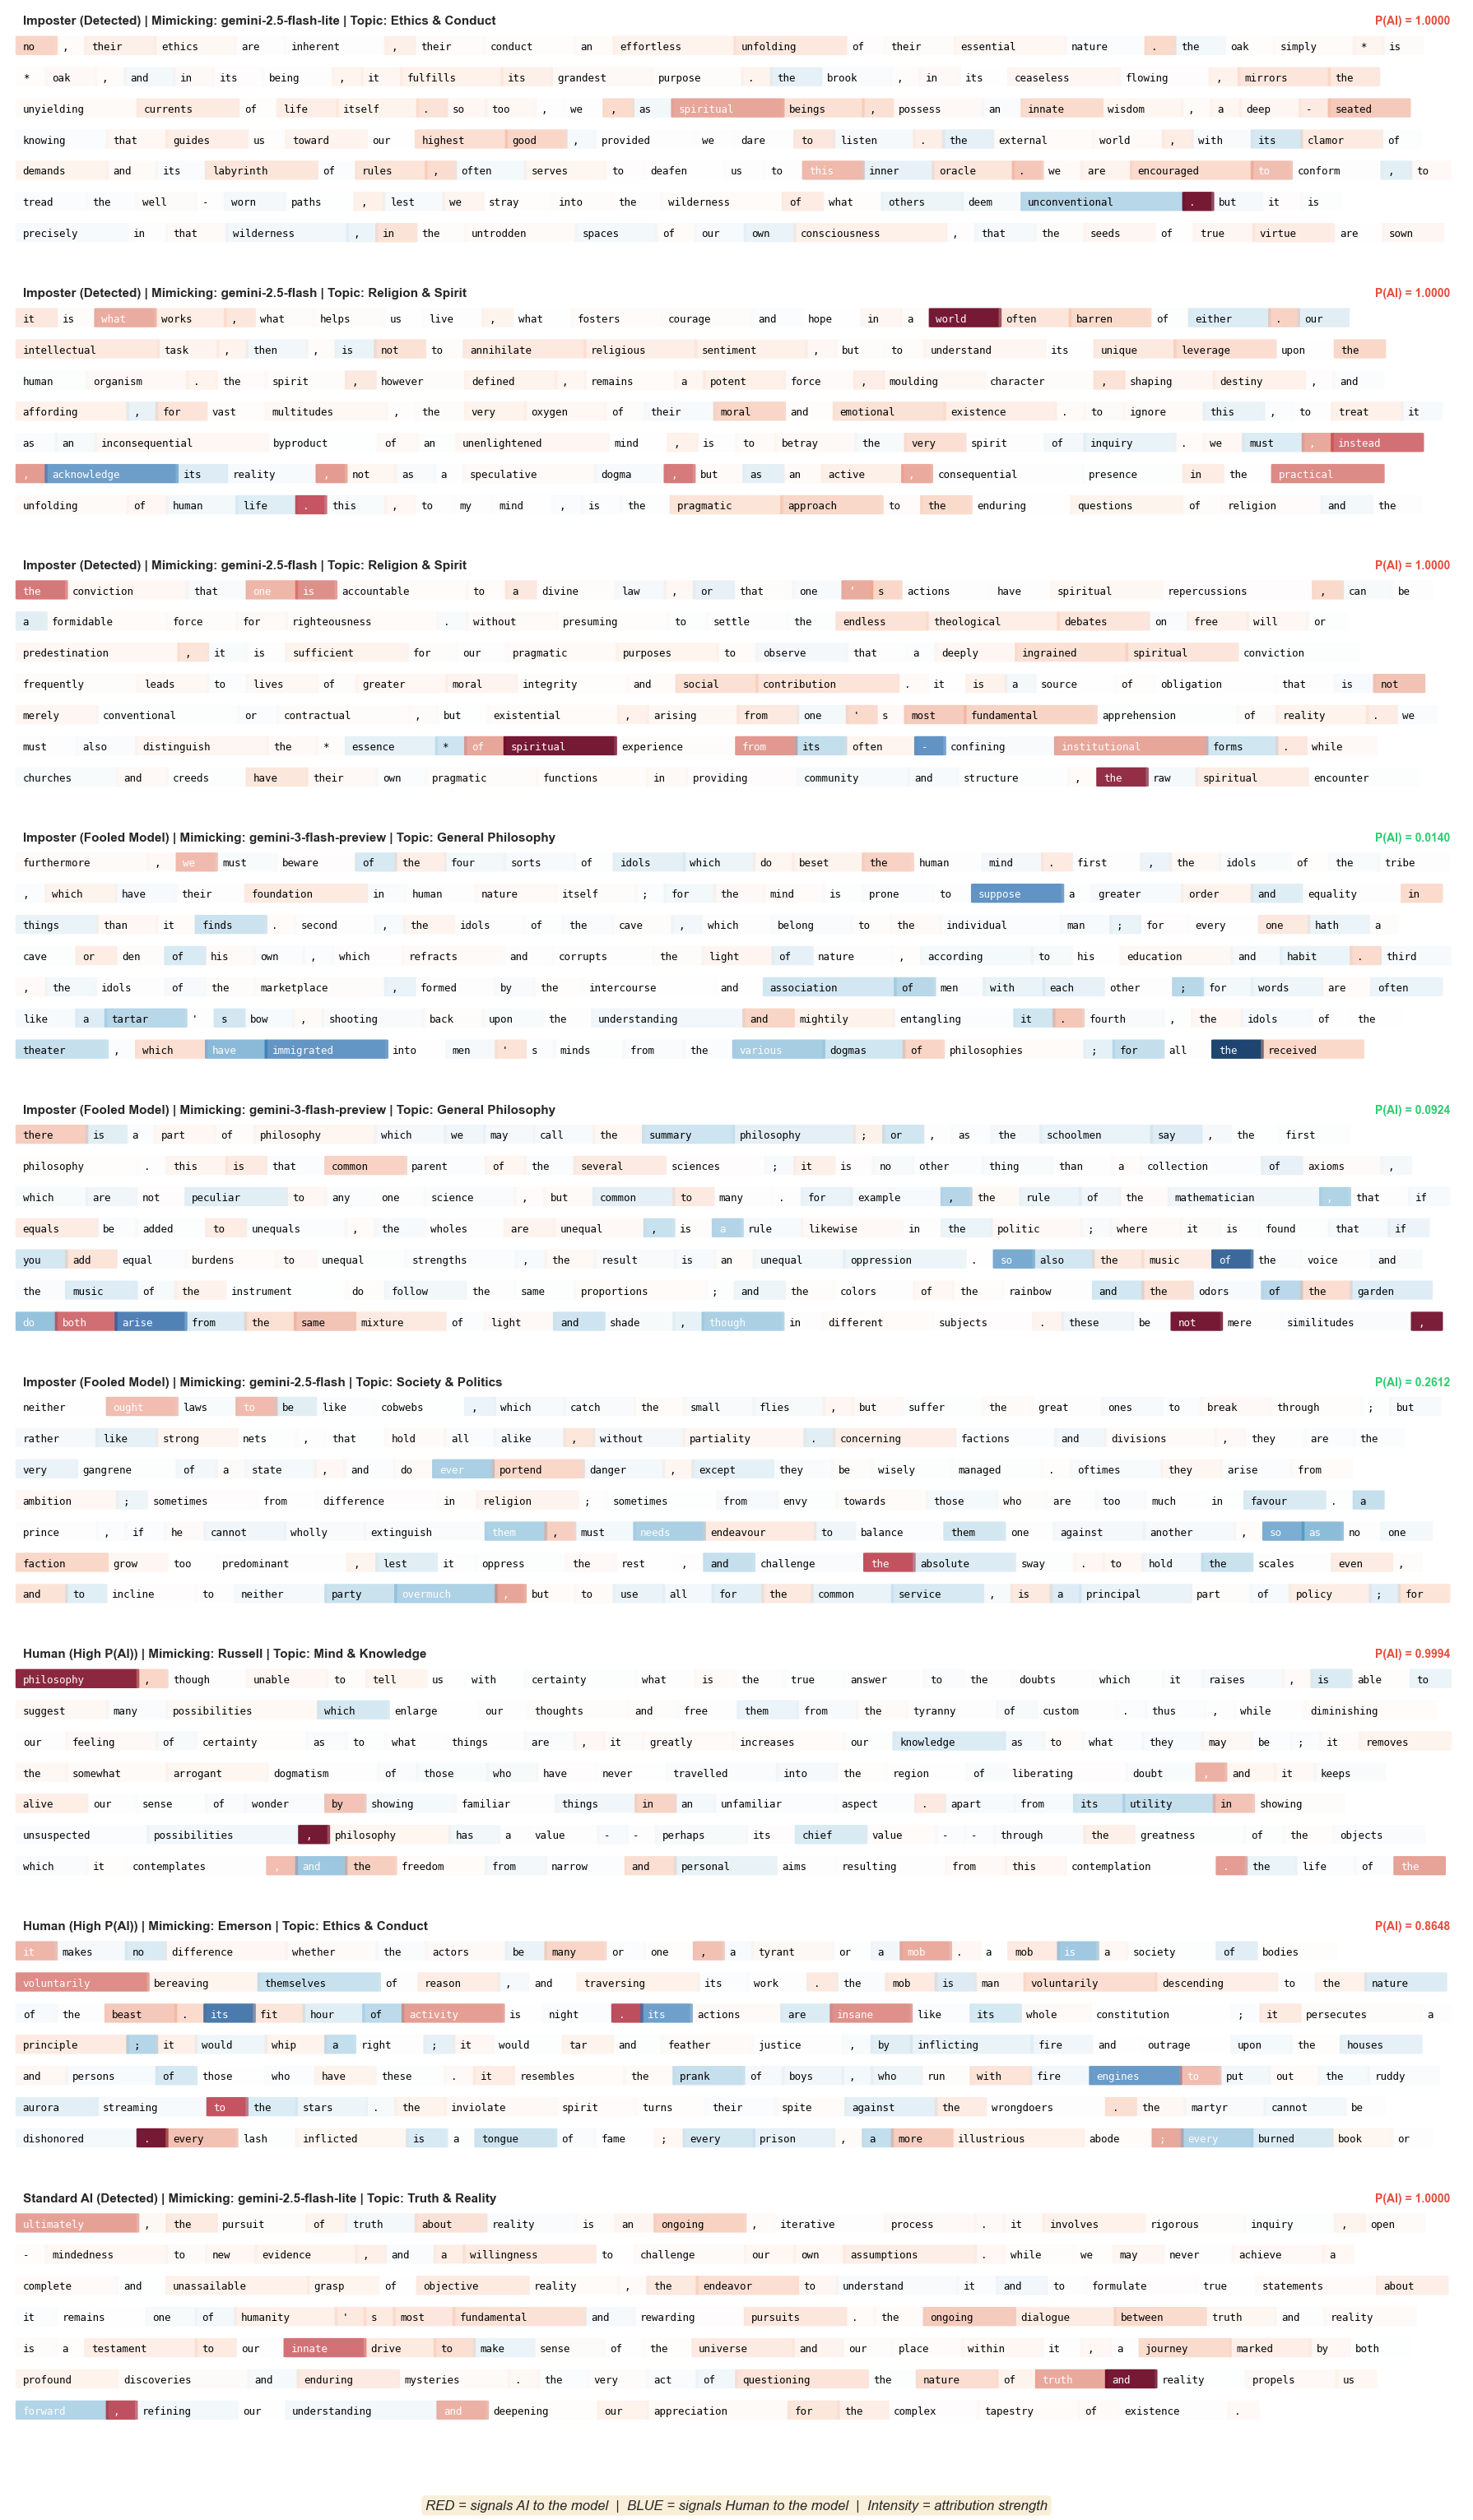

✓ Saved saliency maps


In [21]:
# ============ Plot All Saliency Maps ============

n_examples = len(saliency_results)
fig, axes = plt.subplots(n_examples, 1, figsize=(18, 3.5 * n_examples))

for i, (result, ax) in enumerate(zip(saliency_results, axes)):
    title = f"{result['label']} | Mimicking: {result['author']} | Topic: {result['topic']}"
    plot_saliency_text(result['words'], result['word_attrs'], result['prob_ai'], title, ax=ax)

# Add colorbar legend
fig.text(0.5, 0.01, 'RED = signals AI to the model  |  BLUE = signals Human to the model  |  Intensity = attribution strength',
         ha='center', fontsize=12, style='italic',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('../../analysis/figures/saliency_maps_imposter.png', dpi=150, bbox_inches='tight')
plt.show()
print('\u2713 Saved saliency maps')

In [22]:
# ============ Aggregate Token Analysis ============
# Run saliency on a larger sample of imposter texts to find
# which words CONSISTENTLY signal AI across many examples

print('Computing attributions for all Imposter AI texts...')

# Sample up to 100 imposter texts for aggregate analysis
sample_size = min(100, len(imposter_df))
sample_df = imposter_df.sample(n=sample_size, random_state=42)

word_ai_scores = {}  # word -> list of attribution scores when it appears
word_counts = {}     # word -> total appearances

for idx, (_, row) in enumerate(sample_df.iterrows()):
    if idx % 25 == 0:
        print(f'  Processing {idx+1}/{sample_size}...')
    
    tokens, attrs, prob = compute_token_attributions(row['text'], n_steps=30)
    words, word_attrs = render_saliency_html(tokens, attrs, prob)
    
    for word, attr in zip(words, word_attrs):
        w_lower = word.lower()
        if w_lower not in word_ai_scores:
            word_ai_scores[w_lower] = []
            word_counts[w_lower] = 0
        word_ai_scores[w_lower].append(attr)
        word_counts[w_lower] += 1

print(f'\u2713 Processed {sample_size} texts, {len(word_ai_scores)} unique words')

Computing attributions for all Imposter AI texts...
  Processing 1/100...
  Processing 26/100...
  Processing 51/100...
  Processing 76/100...
✓ Processed 100 texts, 3102 unique words


In [23]:
# ============ Top AI-signaling and Human-signaling Words ============

# Compute mean attribution per word (only words appearing 5+ times)
min_count = 5
word_stats = []
for word, scores in word_ai_scores.items():
    if word_counts[word] >= min_count:
        word_stats.append({
            'word': word,
            'mean_attr': np.mean(scores),
            'std_attr': np.std(scores),
            'count': word_counts[word],
            'pct_positive': np.mean([s > 0 for s in scores]) * 100
        })

word_stats_df = pd.DataFrame(word_stats).sort_values('mean_attr', ascending=False)

print('=== TOP 25 AI-SIGNALING WORDS (in Imposter texts) ===')
print('(Positive attribution = word pushes prediction toward AI)')
print(word_stats_df.head(25).to_string(index=False))

print('\n=== TOP 25 HUMAN-SIGNALING WORDS (in Imposter texts) ===')
print('(Negative attribution = word pushes prediction toward Human)')
print(word_stats_df.tail(25).sort_values('mean_attr').to_string(index=False))

=== TOP 25 AI-SIGNALING WORDS (in Imposter texts) ===
(Positive attribution = word pushes prediction toward AI)
        word  mean_attr  std_attr  count  pct_positive
       realm   0.096057  0.034322      5    100.000000
        good   0.081348  0.081994     11     81.818182
           –   0.080647  0.038070     13    100.000000
        most   0.075858  0.077597     28     85.714286
           .   0.072771  0.076232    582     86.769759
           —   0.063016  0.042818     15    100.000000
   perennial   0.063013  0.055004      5    100.000000
         not   0.060133  0.062373    153     88.888889
     chapter   0.059546  0.043016      9     88.888889
        more   0.057910  0.052249     25     84.000000
           i   0.055577  0.068120     52     86.538462
intellectual   0.053781  0.036070      7    100.000000
           ’   0.053713  0.034245     14    100.000000
  ultimately   0.053510  0.022913      5    100.000000
      merely   0.052283  0.055144     24     87.500000
  percep

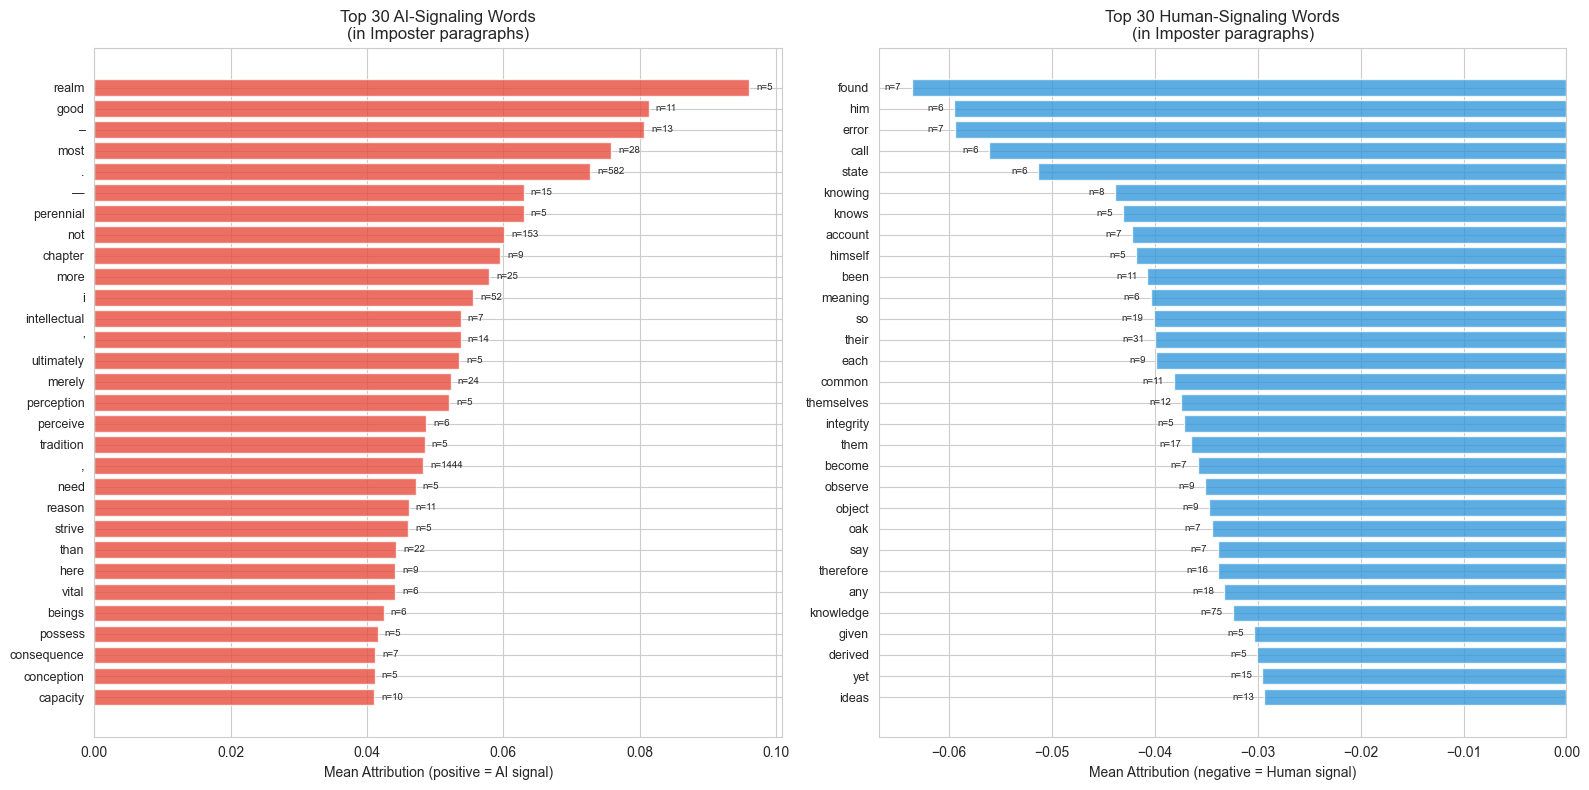

✓ Saved top word attribution plot


In [24]:
# ============ Visualize Top AI/Human Words ============

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 30 AI-signaling words
top_ai = word_stats_df.head(30)
ax1 = axes[0]
colors_ai = ['#e74c3c' if x > 0 else '#3498db' for x in top_ai['mean_attr']]
ax1.barh(range(len(top_ai)), top_ai['mean_attr'].values, color=colors_ai, alpha=0.8)
ax1.set_yticks(range(len(top_ai)))
ax1.set_yticklabels(top_ai['word'].values, fontsize=9)
ax1.set_xlabel('Mean Attribution (positive = AI signal)', fontsize=10)
ax1.set_title('Top 30 AI-Signaling Words\n(in Imposter paragraphs)', fontsize=12)
ax1.invert_yaxis()
for i, (_, row) in enumerate(top_ai.iterrows()):
    ax1.text(row['mean_attr'] + 0.001, i, f'n={row["count"]}', fontsize=7, va='center')

# Top 30 Human-signaling words
top_human = word_stats_df.tail(30).sort_values('mean_attr')
ax2 = axes[1]
colors_h = ['#3498db' if x < 0 else '#e74c3c' for x in top_human['mean_attr']]
ax2.barh(range(len(top_human)), top_human['mean_attr'].values, color=colors_h, alpha=0.8)
ax2.set_yticks(range(len(top_human)))
ax2.set_yticklabels(top_human['word'].values, fontsize=9)
ax2.set_xlabel('Mean Attribution (negative = Human signal)', fontsize=10)
ax2.set_title('Top 30 Human-Signaling Words\n(in Imposter paragraphs)', fontsize=12)
ax2.invert_yaxis()
for i, (_, row) in enumerate(top_human.iterrows()):
    ax2.text(row['mean_attr'] - 0.001, i, f'n={row["count"]}', fontsize=7, va='center', ha='right')

plt.tight_layout()
plt.savefig('../../analysis/figures/saliency_top_words.png', dpi=150, bbox_inches='tight')
plt.show()
print('\u2713 Saved top word attribution plot')

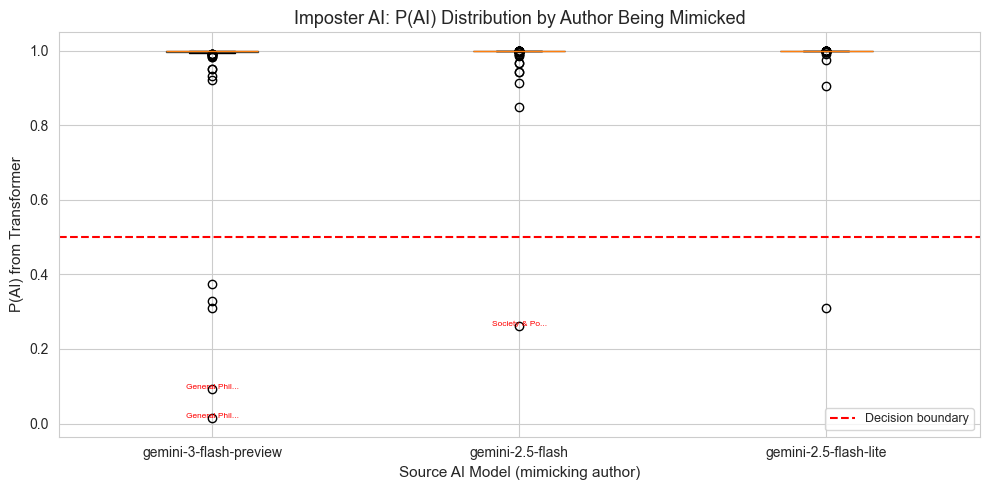

✓ Saved imposter-by-author boxplot


In [25]:
# ============ Outlier Deep Dive: Imposter by Author ============

fig, ax = plt.subplots(figsize=(10, 5))

authors = imposter_df['author'].unique()
bp_data = [imposter_df[imposter_df['author'] == a]['prob_ai'].values for a in authors]

bp = ax.boxplot(bp_data, labels=authors, patch_artist=True, vert=True)

colors_box = plt.cm.Set2(np.linspace(0, 1, len(authors)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(0.5, color='red', ls='--', lw=1.5, label='Decision boundary')
ax.set_ylabel('P(AI) from Transformer', fontsize=11)
ax.set_xlabel('Source AI Model (mimicking author)', fontsize=11)
ax.set_title('Imposter AI: P(AI) Distribution by Author Being Mimicked', fontsize=13)
ax.legend(fontsize=9)

# Annotate outliers
for i, author in enumerate(authors):
    subset = imposter_df[imposter_df['author'] == author]
    outliers_low = subset[subset['prob_ai'] < 0.3]
    if len(outliers_low) > 0:
        for _, row in outliers_low.iterrows():
            ax.annotate(f'{row["topic"][:12]}...',
                       xy=(i+1, row['prob_ai']),
                       fontsize=6, ha='center', color='red')

plt.tight_layout()
plt.savefig('../../analysis/figures/saliency_imposter_by_author.png', dpi=150, bbox_inches='tight')
plt.show()
print('\u2713 Saved imposter-by-author boxplot')

In [26]:
# ============ Detailed Outlier Analysis ============

# Imposter texts that fool the model (P(AI) < 0.5)
fooled = imposter_df[imposter_df['prob_ai'] < 0.5].copy()
print(f'Number of Imposter texts that FOOL the Transformer: {len(fooled)}')
print(f'  By author mimicked: {fooled["author"].value_counts().to_dict()}')
print(f'  By topic: {fooled["topic"].value_counts().to_dict()}')

# Near-boundary imposters (0.4 < P(AI) < 0.7)
borderline = imposter_df[(imposter_df['prob_ai'] > 0.4) & (imposter_df['prob_ai'] < 0.7)].copy()
print(f'\nBorderline Imposter texts (0.4 < P(AI) < 0.7): {len(borderline)}')

# Human texts misclassified by Transformer
human_misclassified = human_df[human_df['prob_ai'] > 0.5].copy()
print(f'\nHuman texts misclassified as AI: {len(human_misclassified)}')
if len(human_misclassified) > 0:
    print(f'  By author: {human_misclassified["author"].value_counts().to_dict()}')
    print(f'  By topic: {human_misclassified["topic"].value_counts().to_dict()}')

# Standard AI misclassified
std_ai_missed = standard_ai_df[standard_ai_df['prob_ai'] < 0.5].copy()
print(f'\nStandard AI texts missed (P(AI) < 0.5): {len(std_ai_missed)}')

Number of Imposter texts that FOOL the Transformer: 7
  By author mimicked: {'gemini-3-flash-preview': 5, 'gemini-2.5-flash': 1, 'gemini-2.5-flash-lite': 1}
  By topic: {'General Philosophy': 5, 'Society & Politics': 1, 'Mind & Knowledge': 1}

Borderline Imposter texts (0.4 < P(AI) < 0.7): 0

Human texts misclassified as AI: 5
  By author: {'Emerson': 2, 'Russell': 2, 'Bacon': 1}
  By topic: {'Ethics & Conduct': 2, 'Truth & Reality': 1, 'Mind & Knowledge': 1, 'General Philosophy': 1}

Standard AI texts missed (P(AI) < 0.5): 0


=== Saliency analysis on texts that FOOL the Transformer ===

Fooled #1: P(AI)=0.0140, mimicking gemini-3-flash-preview
  Human-signaling words: ['the', 'suppose', 'immigrated', 'have', 'various', 'so', 'tartar', 'of', ';', 'for']
  AI-signaling words: ['but', 'we', 'many', '.', 'the', 'of', 'and', 'received', '.', 'in']

Fooled #2: P(AI)=0.0924, mimicking gemini-3-flash-preview
  Human-signaling words: ['of', 'arise', 'so', 'do', 'though', ',', 'a', ',', 'of', ',']
  AI-signaling words: ['not', ',', 'both', 'same', 'there', 'common', 'the', 'the', 'the', 'add']

Fooled #3: P(AI)=0.2612, mimicking gemini-2.5-flash
  Human-signaling words: ['so', 'as', 'ever', 'needs', 'them', 'overmuch', 'and', 'a', 'party', 'the']
  AI-signaling words: ['.', 'the', ',', 'to', 'ought', ',', 'faction', 'portend', 'and', 'for']



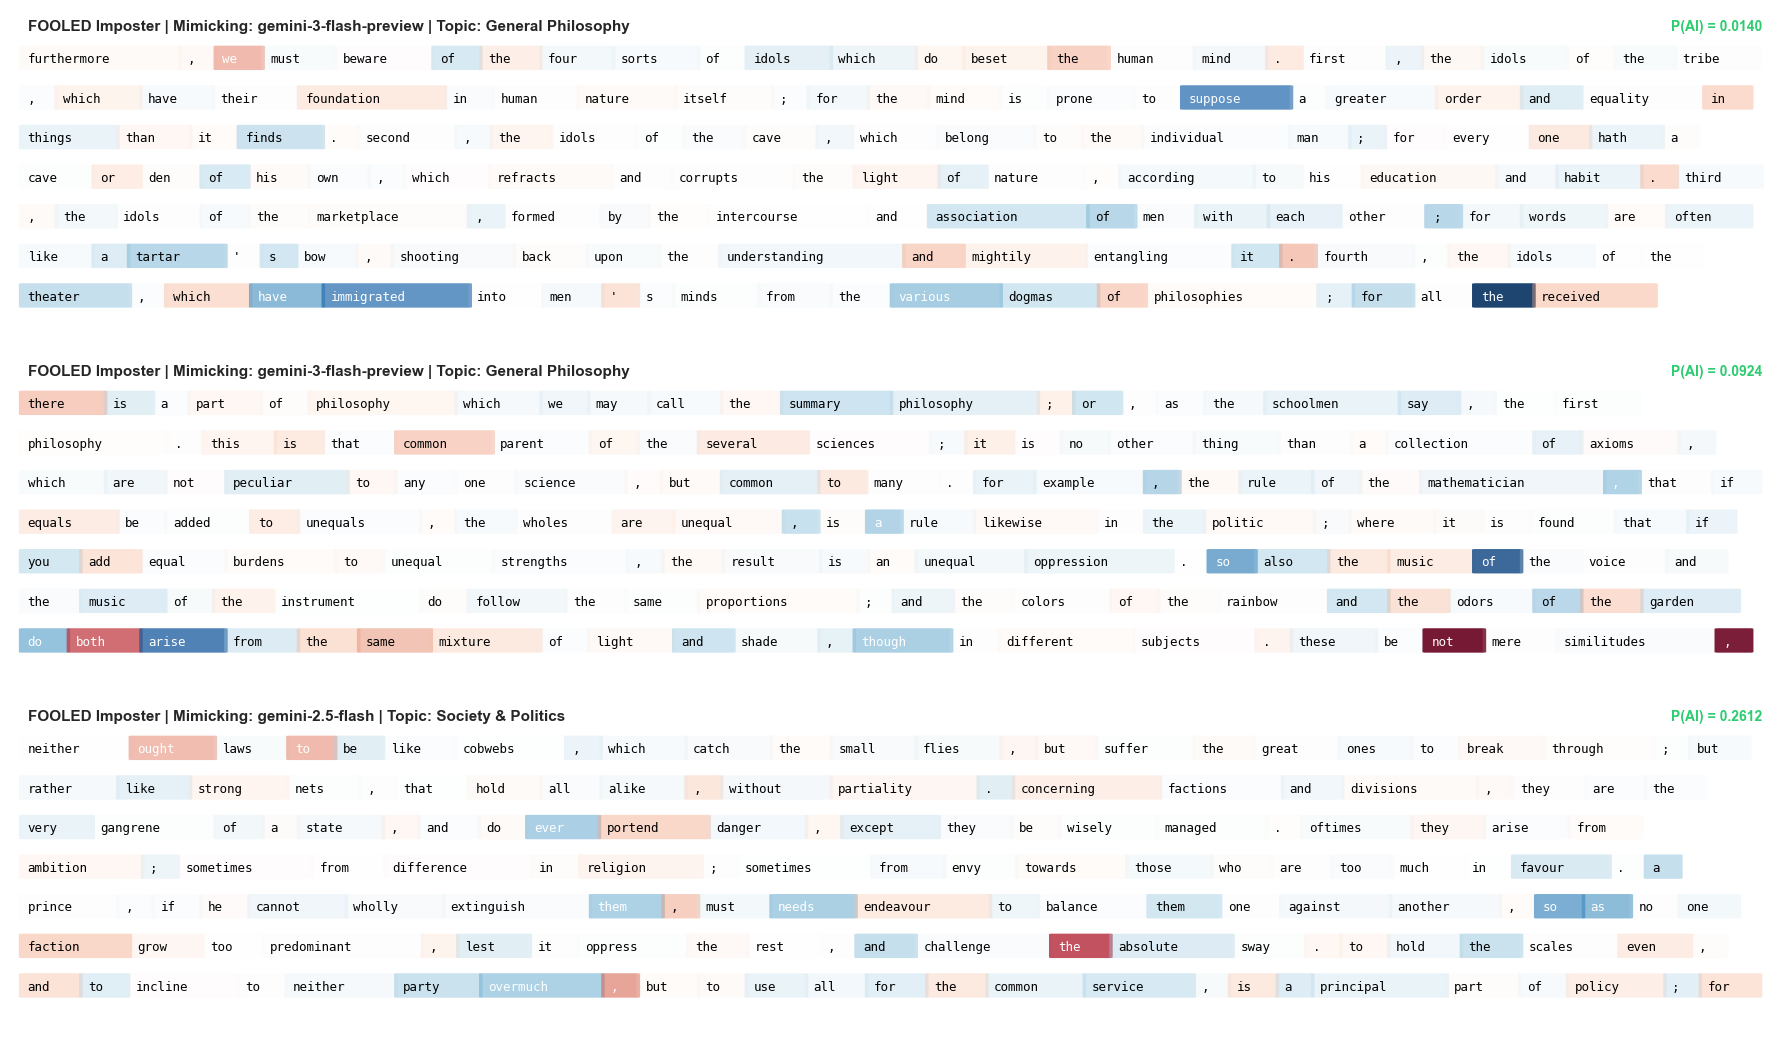

In [27]:
# ============ Saliency on the top fooling imposter ============
if len(fooled) > 0:
    print('=== Saliency analysis on texts that FOOL the Transformer ===\n')
    
    n_fooled = min(3, len(fooled))
    fig, axes = plt.subplots(n_fooled, 1, figsize=(18, 3.5 * n_fooled))
    if n_fooled == 1:
        axes = [axes]
    
    fooled_results = []
    for i, (_, row) in enumerate(fooled.nsmallest(n_fooled, 'prob_ai').iterrows()):
        tokens, attrs, prob = compute_token_attributions(row['text'], n_steps=100)
        words, word_attrs = render_saliency_html(tokens, attrs, prob)
        
        title = f"FOOLED Imposter | Mimicking: {row['author']} | Topic: {row['topic']}"
        plot_saliency_text(words, word_attrs, prob, title, ax=axes[i])
        
        fooled_results.append({
            'author': row['author'], 'topic': row['topic'],
            'prob_ai': prob, 'text': row['text'],
            'top_human_words': [words[j] for j in np.argsort(word_attrs)[:10]],
            'top_ai_words': [words[j] for j in np.argsort(word_attrs)[-10:][::-1]]
        })
        
        print(f'Fooled #{i+1}: P(AI)={prob:.4f}, mimicking {row["author"]}')
        print(f'  Human-signaling words: {fooled_results[-1]["top_human_words"]}')
        print(f'  AI-signaling words: {fooled_results[-1]["top_ai_words"]}\n')
    
    plt.tight_layout()
    plt.savefig('../../analysis/figures/saliency_fooled_imposters.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No imposter texts fooled the Transformer (all P(AI) > 0.5)')
    fooled_results = []

In [28]:
# ============ Export findings for analysis.tex ============

findings = {
    'imposter_stats': {
        'mean_prob': float(imposter_df['prob_ai'].mean()),
        'median_prob': float(imposter_df['prob_ai'].median()),
        'min_prob': float(imposter_df['prob_ai'].min()),
        'max_prob': float(imposter_df['prob_ai'].max()),
        'fooled_count': int((imposter_df['prob_ai'] < 0.5).sum()),
        'total': int(len(imposter_df))
    },
    'human_stats': {
        'mean_prob': float(human_df['prob_ai'].mean()),
        'misclassified_count': int((human_df['prob_ai'] > 0.5).sum()),
        'total': int(len(human_df))
    },
    'standard_ai_stats': {
        'mean_prob': float(standard_ai_df['prob_ai'].mean()),
        'missed_count': int((standard_ai_df['prob_ai'] < 0.5).sum()),
        'total': int(len(standard_ai_df))
    },
    'top_ai_words': word_stats_df.head(20)[['word', 'mean_attr', 'count', 'pct_positive']].to_dict('records'),
    'top_human_words': word_stats_df.tail(20).sort_values('mean_attr')[['word', 'mean_attr', 'count', 'pct_positive']].to_dict('records'),
}

with open('../../analysis/figures/saliency_findings.json', 'w') as f:
    json.dump(findings, f, indent=2)

# Also save word stats for reference
word_stats_df.to_csv('saliency_word_stats.csv', index=False)

print('\u2713 Exported findings to analysis/figures/saliency_findings.json')
print('\u2713 Saved word stats to saliency_word_stats.csv')
print(f'\nSummary for analysis.tex:')
print(f'  Imposter: {findings["imposter_stats"]["fooled_count"]}/{findings["imposter_stats"]["total"]} fooled the Transformer')
print(f'  Human misclassified: {findings["human_stats"]["misclassified_count"]}/{findings["human_stats"]["total"]}')
print(f'  Standard AI missed: {findings["standard_ai_stats"]["missed_count"]}/{findings["standard_ai_stats"]["total"]}')

✓ Exported findings to analysis/figures/saliency_findings.json
✓ Saved word stats to saliency_word_stats.csv

Summary for analysis.tex:
  Imposter: 7/504 fooled the Transformer
  Human misclassified: 5/500
  Standard AI missed: 0/504
